# Previsão de Engajamento - Classificação

Este notebook define modelos e hiperparâmetros e executa um validação cruzada aninhada com grid search para otimização de hiperparâmetros e treinamento.

- Entrada: `full-preproc2-inputs` e `full-preproc2-outputs`
- Saída: `resultados/resultados50p_{START_DATE_STR}_{SUB_DATASET}.npy`


In [38]:
#@title Importações de pacote
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [39]:
BASE_PATH = 'dados/preprocessed/'
MODEL_NAME = 'all-MiniLM-paraphrase-multilingual'

# 1 - Carregando os Dados

Carregando dados brutos gerais.

In [40]:
dfx = pd.read_excel(BASE_PATH + 'full-preproc2-inputs_'+ MODEL_NAME +'.xlsx', index_col='ID')
dfx.drop(columns=["Only Hashtags"],inplace=True)
dfx.head()

,Candidato_Bolsonaro,Candidato_Lula,x1,x2,x3,x4,x5,x6,x7,x8,...,x375,x376,x377,x378,x379,x380,x381,x382,x383,x384
ID,,,,,,,,,,,,,,,,,,,,,
7114971700365692165,1,0,-0.035405,0.091901,0.029305,-0.098718,0.243411,0.111185,0.209296,0.246135,...,0.175389,-0.227796,-0.141506,-0.010863,0.124115,0.060907,0.403370,-0.108669,-0.133018,0.144618
7115033431473474822,0,1,-0.222600,0.258170,0.165599,-0.210579,0.359918,-0.001123,0.007566,0.102354,...,0.370087,-0.112563,-0.277257,0.095219,-0.293415,0.101862,0.038032,0.054848,0.059788,0.128184
7115050482179050758,1,0,0.024929,0.079934,0.098492,-0.100231,0.224104,0.025696,0.261186,0.223540,...,0.168720,-0.311732,-0.105087,-0.059519,0.052269,0.108190,0.341778,-0.142647,-0.096181,0.125113
7115120078982630661,1,0,0.037256,0.072214,-0.000965,-0.107916,0.288683,0.103231,0.224356,0.107725,...,0.202172,-0.211109,-0.122603,0.045138,0.120379,0.205129,0.261554,-0.083097,-0.185110,0.220620
7115161088219565317,1,0,0.184212,-0.063834,-0.014328,-0.073712,0.067048,-0.046129,0.184030,0.259894,...,0.109674,-0.212620,-0.229578,-0.191411,0.090878,0.120460,0.276041,-0.130134,-0.236629,0.108136


In [41]:
dfy_full = pd.read_excel(BASE_PATH + 'full-preproc2-outputs_'+ MODEL_NAME +'.xlsx', index_col='ID')
dfy_full.head()

,Curtidas,Curtidas-Log,Curtidas-MinMax,Curtidas-Log-MinMax,Curtidas-2Classes-50p
ID,,,,,
7114971700365692165,24400,4.387390,0.003881,0.299717,0
7115033431473474822,11700,4.068186,0.003970,0.281879,0
7115050482179050758,9163,3.962038,0.001197,0.173869,0
7115120078982630661,3485,3.542203,0.000197,0.049653,0
7115161088219565317,22100,4.344392,0.003476,0.286995,0


## 1.1 - Escolha do Dataset (ALTERE)

In [42]:
from util import filter_dataset

# 'geral', 'lula' ou 'bolsonaro'
SUB_DATASET = 'lula'

TARGET_COL = 'Curtidas-2Classes-50p'

In [43]:
dfx, dfy = filter_dataset(dfx, dfy_full, SUB_DATASET, TARGET_COL)

Dataset LULA (indicador 1)


In [44]:
dfx.columns
dfx.shape

(1967, 384)

In [45]:

dfy.head()
#dfy.shape

ID
7115033431473474822    0
7115174031162215686    1
7115357413712153861    1
7115560675824422149    1
7115793869152734470    0
Name: Curtidas-2Classes-50p, dtype: int64

## 1.2 - Informações do Treinamento (ALTERE)

In [46]:
from datetime import datetime

RANDOM_STATE = 1231

START_DATE_STR = datetime.now().strftime("%Y-%m-%d-%Hh%Mm")
#print(start_date_str)

metadata = dict()
metadata['date'] = START_DATE_STR
metadata['subdataset'] = SUB_DATASET
metadata['target'] = TARGET_COL
metadata['random_state'] = RANDOM_STATE

metadata['description'] =  f'''Treinamento com modelos com os 
dados balanceados (50p), com o dataset {SUB_DATASET}, com todos os modelos 
e com todos os ENSEMBLE, com a correção de escala para a MLP,
variando class_weight para os modelos que suportam'''

# 2 - Modelos

In [47]:
from sklearn.pipeline import Pipeline
from data_transformations_util import IdentityTransformer

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [49]:
lista_modelos = [
    {
        "nome_do_modelo": 'MLP Neural Network',
        "estimador": Pipeline([
            ('pca', PCA()),
            ('scaler', StandardScaler()), 
            ('predictor', MLPClassifier(random_state=42))
        ]),
        "parametros": {
            'pca': [PCA(n_components=0.50), PCA(n_components=0.65), PCA(n_components=0.80), IdentityTransformer()],
            'scaler': [IdentityTransformer(), StandardScaler(), MinMaxScaler()],
            'predictor__hidden_layer_sizes': [(256,), (512,), (1024,)],  # Number of neurons in the hidden layer
            'predictor__learning_rate_init': [0.001, 0.01, 0.05],        # Learning rate
        }
    },
    {
        "nome_do_modelo": 'Support Vector Machine',
        "estimador": Pipeline([
            ('pca', PCA()),
            ('scaler', StandardScaler()), 
            ('predictor', SVC(random_state=42))   #SVC(probability=True) # muito lento?  Tempo médio de treinamento sem proba: 21.55 segundos / com proba: 35.11 segundos
        ]),
        "parametros": {
            'pca': [PCA(n_components=0.50), PCA(n_components=0.65), PCA(n_components=0.80), IdentityTransformer()],
            'scaler': [IdentityTransformer(), StandardScaler(), MinMaxScaler()],
            'predictor__class_weight': ['balanced', None], 
            'predictor__C': [0.1, 1.0, 10.0, 20.0, 50.0],
            'predictor__gamma': ['scale', 'auto'],
            'predictor__kernel': ['rbf', 'sigmoid']  # removi 'linear' porque deixava lento!
        }
    },
    {
        "nome_do_modelo": 'Random Forest',
        "estimador": Pipeline([
            ('pca', PCA()),
            ('predictor', RandomForestClassifier(random_state=42))
        ]),
        "parametros": {
            'pca': [PCA(n_components=0.50), PCA(n_components=0.65), PCA(n_components=0.80), IdentityTransformer()],
            'predictor__n_estimators': [10, 30, 70], 
            'predictor__class_weight': ['balanced', None], 
            'predictor__max_depth': [3, 4, 5, None],
            'predictor__min_samples_split': [2, 4, 8]
        }
    },
    {
        "nome_do_modelo": 'Logistic Regression',
        "estimador": Pipeline([
            ('pca', PCA()),
            ('scaler', StandardScaler()), 
            ('predictor', LogisticRegression(solver='saga', random_state=42))   # Saga is the only solver to support the 3 options for 'penalty'
        ]),
        "parametros": {
            'pca': [PCA(n_components=0.50), PCA(n_components=0.65), PCA(n_components=0.80), IdentityTransformer()],
            'scaler': [IdentityTransformer(), StandardScaler(), MinMaxScaler()],
            'predictor__class_weight': ['balanced', None], 
            'predictor__C': [0.01, 0.1, 1.0, 2.0],         # Regularization parameter
            'predictor__penalty': ['l1', 'l2', None]       # Penalty term
        }
    },
    {
        "nome_do_modelo": 'KNN',
        "estimador": Pipeline([
            ('pca', PCA),
            ('scaler', StandardScaler()), 
            ('predictor', KNeighborsClassifier())
        ]),
        "parametros": {
            'pca': [PCA(n_components=0.50), PCA(n_components=0.65), PCA(n_components=0.80), IdentityTransformer()],
            'scaler': [IdentityTransformer(), StandardScaler(), MinMaxScaler()],
            'predictor__n_neighbors': [5, 10, 15, 20], 
            'predictor__weights': ['uniform', 'distance'], 
            'predictor__p': [1, 2]
        }
    },

]

In [50]:
BASIC_MODEL_NAMES = [ mdl["nome_do_modelo"] for mdl in lista_modelos ]
metadata['basic_models'] = BASIC_MODEL_NAMES

BASIC_MODEL_NAMES

['MLP Neural Network',
 'Support Vector Machine',
 'Random Forest',
 'Logistic Regression',
 'KNN']

# 3 - Treinamento

In [51]:
from classification_train_util import nested_cross_validation_grid_search

A linha abaixo executa nested cross-validation, com um grid search nos *inner folds*, para cada modelo.




 **** RESULTADO DOS MODELOS + CURVAS ROC E PR ****

Treinando modelo MLP Neural Network ....

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



-- coletando e armazenando resultados --

 - Acurácia   : 0.6548 +/- 0.02484
 - Precisão   : 0.6942 +/- 0.06625
 - Revocação  : 0.6053 +/- 0.15583
 - F1 - Score : 0.6267 +/- 0.06856
 - ROC - AUC  : 0.7434 +/- 0.00906
 - PR - AUC   : 0.7593 +/- 0.01814
 - Tempo médio de treinamento: 549.64 segundos


Treinando modelo Support Vector Machine .....
-- coletando e armazenando resultados --

 - Acurácia   : 0.6726 +/- 0.02221
 - Precisão   : 0.6682 +/- 0.03098
 - Revocação  : 0.6918 +/- 0.02419
 - F1 - Score : 0.6788 +/- 0.01334
 - ROC - AUC  : 0.7416 +/- 0.01025
 - PR - AUC   : 0.7511 +/- 0.01871
 - Tempo médio de treinamento: 113.20 segundos


Treinando modelo Random Forest .....
-- coletando e armazenando resultados --

 - Acurácia   : 0.6528 +/- 0.00491
 - Precisão   : 0.6362 +/- 0.00429
 - Revocação  : 0.7131 +/- 0.02127
 - F1 - Score : 0.6723 +/- 0.00869
 - ROC - AUC  : 0.7106 +/- 0.00770
 - PR - AUC   : 0.6989 +/- 0.01789
 - Tempo médio de treinamento: 96.46 segundos


Treinando mode

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


..
-- coletando e armazenando resultados --

 - Acurácia   : 0.6899 +/- 0.01020
 - Precisão   : 0.6875 +/- 0.00834
 - Revocação  : 0.6958 +/- 0.02465
 - F1 - Score : 0.6914 +/- 0.01396
 - ROC - AUC  : 0.7529 +/- 0.00875
 - PR - AUC   : 0.7589 +/- 0.01487
 - Tempo médio de treinamento: 65.44 segundos


Treinando modelo KNN .....
-- coletando e armazenando resultados --

 - Acurácia   : 0.6101 +/- 0.00712
 - Precisão   : 0.5807 +/- 0.00680
 - Revocação  : 0.7915 +/- 0.01510
 - F1 - Score : 0.6698 +/- 0.00611
 - ROC - AUC  : 0.6874 +/- 0.01413
 - PR - AUC   : 0.6590 +/- 0.01471
 - Tempo médio de treinamento: 25.04 segundos


Terminado em 14/03/2025 00:58:06


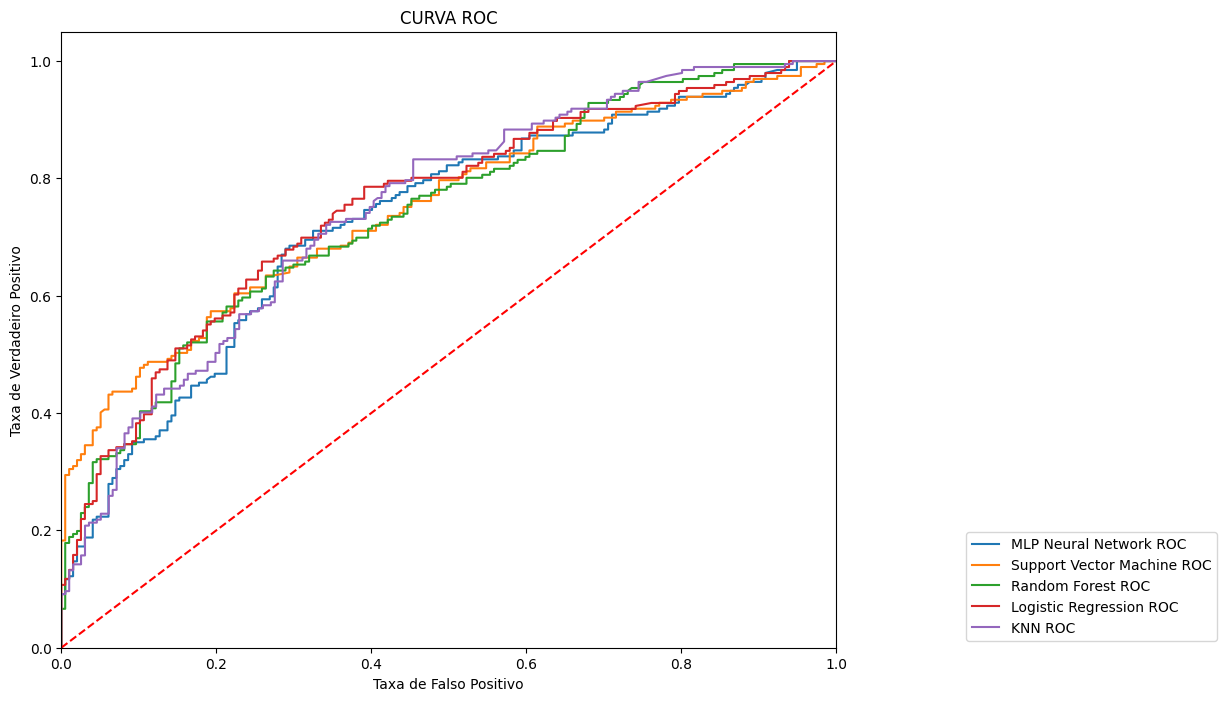

In [52]:

last_run_basic = nested_cross_validation_grid_search(lista_modelos, dfx, dfy, 5, 5, rand_state=RANDOM_STATE)


## 3.3 - Treina Ensembles (não foi publicado)

In [53]:
from copy import deepcopy

from ensemble_train_util import select_best_models_of_type_fn, select_best_models_per_fold
from ensemble_train_util import train_ensemble

In [54]:
last_run_all = deepcopy(last_run_basic)

In [55]:
#models_list = ['MLP Neural Network', 'Support Vector Machine', 'Random Forest', 'Logistic Regression', 'KNN']

for model_name in BASIC_MODEL_NAMES:
    print(f"\n\n\n **** TREINANDO ENSEMBLE PARA {model_name} ****\n")
    contracted_name = ''.join([name[0] for name in model_name.split()])
    results_ensemble = train_ensemble(select_best_models_of_type_fn(model_name), last_run_all, dfx, dfy, name_prefix=contracted_name)

    # merge results with results_with_ensemble
    last_run_all.update(results_ensemble)




 **** TREINANDO ENSEMBLE PARA MLP Neural Network ****

.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(





 **** TREINANDO ENSEMBLE PARA Support Vector Machine ****

..........


 **** TREINANDO ENSEMBLE PARA Random Forest ****

..........


 **** TREINANDO ENSEMBLE PARA Logistic Regression ****

.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(





 **** TREINANDO ENSEMBLE PARA KNN ****

..........

In [56]:
results_ensemble = train_ensemble(select_best_models_per_fold, last_run_basic, dfx, dfy, name_prefix="BPF")  # BPF - best per fold

# check if keys have no intersection (no common key)
assert len(set(last_run_all.keys()) & set(results_ensemble.keys())) == 0

# merge results with results_with_ensemble
last_run_all.update(results_ensemble)

.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


.

c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Kabum\virtual_enviroment_llm\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## 3.4 - Salva Resultados

In [57]:
from util import save_results

In [58]:
last_run_all.keys()

dict_keys(['MLP Neural Network', 'Support Vector Machine', 'Random Forest', 'Logistic Regression', 'KNN', 'MNN-hard-vote', 'MNN-soft-vote', 'SVM-hard-vote', 'SVM-soft-vote', 'RF-hard-vote', 'RF-soft-vote', 'LR-hard-vote', 'LR-soft-vote', 'K-hard-vote', 'K-soft-vote', 'BPF-hard-vote', 'BPF-soft-vote'])

In [59]:
OUTPUT_FILE_PATH = f'resultados/resultados50p_{START_DATE_STR}_{SUB_DATASET}({MODEL_NAME}).npy'

save_results(OUTPUT_FILE_PATH, last_run_all, metadata)

print("Arquivo salvo:", OUTPUT_FILE_PATH)

Arquivo salvo: resultados/resultados50p_2025-03-13-23h46m_lula(all-MiniLM-paraphrase-multilingual).npy


----

# FIM